# Inception model - Pasquet

### Packages

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import median_abs_deviation
from tensorflow.keras.metrics import mse

from tools import *
from model_inception import *

In [64]:
import tensorflow as tf

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2023-05-12 05:35:21.097811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 36123 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2023-05-12 05:35:21.107530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 36123 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


### Data preparation

In [61]:
!ls /global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp

download  img_30k.npy  z_30k.npy


In [5]:
img_path = '/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/img_30k.npy'
z_path = '/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/z_30k.npy'

img = np.load(img_path)
z = np.load(z_path)

scaling = []
for i in range(img.shape[-1]):
    sigma = 1.4826*median_abs_deviation(img[...,i].flatten())
    scaling.append(sigma)

img = np.arcsinh(img / scaling / 3.)

n = img.shape[0]
data = {}
data['train'] = [img[:int(n/2),...], z[:int(n/2)]]
data['val'] = [img[int(n/2):int(3*n/4),...], z[int(n/2):int(3*n/4)]]
data['test'] = [img[int(3*n/4):,...], z[int(3*n/4):]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


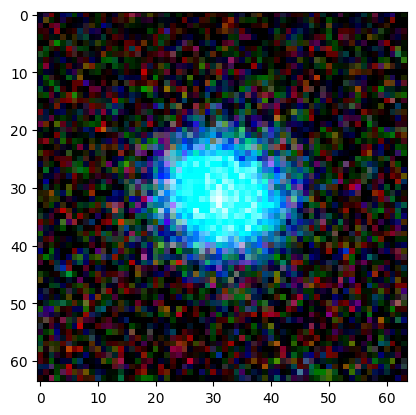

In [6]:
# Check transformed images
plt.imshow(data['train'][0][0, ..., :3]);

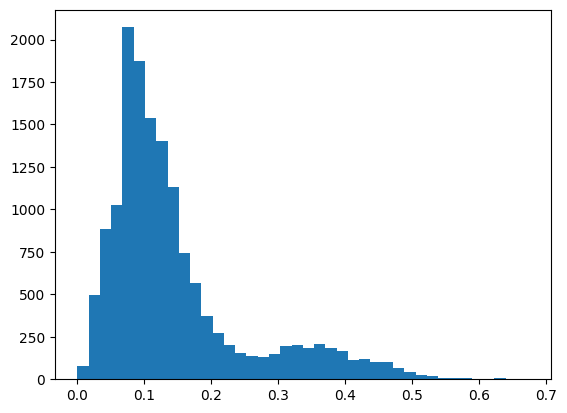

In [7]:
plt.hist(data['train'][1], bins=40);

### Regular Model training

In [7]:
model = model_tf2()

2023-05-11 06:48:19.120416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37327 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [8]:
model.summary()

Model: "incept_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   8064        ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 64, 64, 64)   262144      ['conv2d[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 32, 32, 64)  0           ['p_re_lu[0][0]']                
 ing2D)                                                                                

In [9]:
model.compile(optimizer='adam', loss=mse)

In [10]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception', update_freq='batch')


model.fit(x = data['train'][0], 
          y = data['train'][1],
          batch_size = 64,
          validation_data=(data['val'][0], data['val'][1]),
          steps_per_epoch=15000//64,
          epochs=10,
          callbacks=[lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


2023-05-11 06:48:27.595181: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-05-11 06:48:29.328603: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


234/234 [==============================] - 17s 38ms/step - loss: 0.1934 - val_loss: 0.0019 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/10
234/234 [==============================] - 8s 34ms/step - loss: 0.0015 - val_loss: 0.0017 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/10
234/234 [==============================] - 8s 34ms/step - loss: 0.0012 - val_loss: 0.0013 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/10
234/234 [==============================] - 8s 34ms/step - loss: 0.0012 - val_loss: 0.0014 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/10
234/234 [==============================] - 8s 35ms/step - loss: 9.9914e-04 - val_loss: 0.0010 - lr: 6.5610e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.00059049.
Epoch 6/10
234/234 [===========

In [11]:
# Get the prediction and plot the results
preds = model.predict(data['test'][0]).squeeze()

235/235 [==============================] - 2s 6ms/step


In [12]:
preds.shape

(7500,)

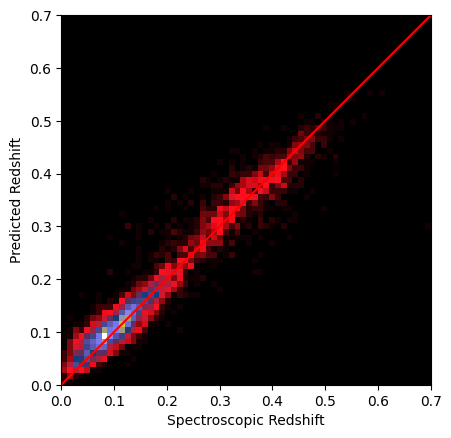

In [13]:
plt.hist2d(data['test'][1], preds, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [14]:
dz, pred_bias, smad, out_frac = metrics(data['test'][1], preds)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0058


<IPython.core.display.Latex object>

Outlier fraction: 3.59%


### With Reddening

Additional feature used in Pasquet's article, that improves the estimated redshifts.

In [15]:
data_download = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

In [16]:
cat = pd.DataFrame(data_download["labels"][:30000] )
cat.columns

Index(['imageID', 'specObjID', 'bestObjID', 'class', 'subClass', 'z', 'zErr',
       'objID', 'type', 'flags', 'ra', 'dec', 'l', 'b', 'dered_petro_u',
       'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i',
       'petroMagErr_z', 'zphot', 'dzphot', 'zphot_avg', 'zphot_reliable',
       'e_bv_sfd', 'primtarget', 'sectarget', 'targettype', 'spectrotype',
       'Column1', 'v_disp', 'release', 'bptclass', 'lgm_tot_p50',
       'sfr_tot_p50', 'specsfr_tot_p50', 'oh_p50', 'logMass_median',
       'ssfr_mean', 'age_mean', 'tau_mean', 't_age_mean', 'metallicity_mean',
       'dust1_mean', 'dust2_mean', 'EBV', 'fracDev_r', 'deVAB_r', 'deVPhi_r',
       'expAB_r', 'expPhi_r', 'petroR90_r', 'deVRad_r', 'expRad_r',
       'probPSF_r', 'extinction_u', 'extinction_g', 'extinction_r',
       'extinction_i', 'extinction_z'],
      dtype='object')

In [17]:
EBV = cat.EBV
EBV.shape

(30000,)

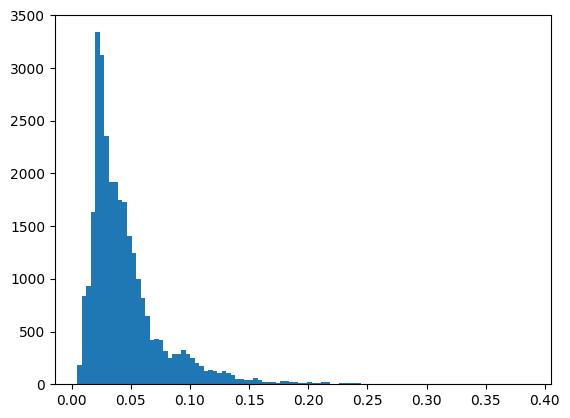

In [18]:
plt.hist(EBV, bins=100);

In [20]:
# Split into train, val and test taking 1/2, 1/4 and 1/4 respectively
EBV_train = EBV[:15000]
EBV_val = EBV[15000:22500]
EBV_test = EBV[22500:]

In [21]:
model_ebv = model_tf2(with_ebv=True)

In [22]:
model_ebv.compile(optimizer='adam', loss=mse)

In [23]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception_w_EBV', update_freq='batch')

model_ebv.fit(x = [data['train'][0], EBV_train], 
          y = data['train'][1],
          batch_size = 64,
          validation_data=([data['val'][0], EBV_val], data['val'][1]),
          steps_per_epoch=15000//64,
          epochs=10,
          callbacks=[lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
234/234 [==============================] - 11s 40ms/step - loss: 0.3733 - val_loss: 0.0016 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/10
234/234 [==============================] - 8s 35ms/step - loss: 0.0015 - val_loss: 0.0018 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/10
234/234 [==============================] - 8s 35ms/step - loss: 0.0012 - val_loss: 0.0015 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/10
234/234 [==============================] - 8s 35ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/10
234/234 [==============================] - 8s 35ms/step - loss: 8.7572e-04 - val_loss: 9.3528e-04 - lr: 6.5610e-04

Epoch 6: LearningRat

In [24]:
# Get the prediction and plot the results
preds_ebv = model_ebv.predict([data['test'][0], EBV_test]).squeeze()

235/235 [==============================] - 2s 6ms/step


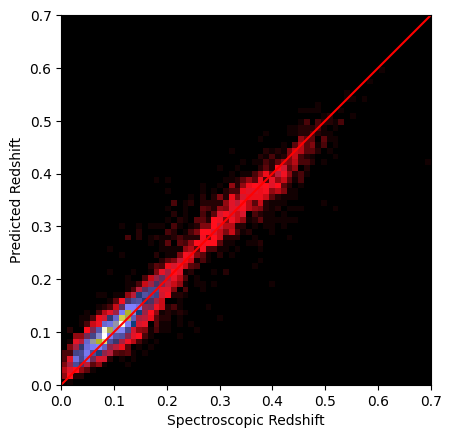

In [25]:
plt.hist2d(data['test'][1], preds_ebv, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

In [26]:
dz, pred_bias, smad, out_frac = metrics(data['test'][1], preds_ebv)
print_metrics(pred_bias, smad, out_frac)

Prediction bias: 0.0050


<IPython.core.display.Latex object>

Outlier fraction: 3.32%


### With distribitions output 

In [8]:
import tensorflow_probability as tfp
tfd = tfp.distributions

In [9]:
def model_tf2(with_ebv = False, output_distrib=False, num_components=16):
    
    Image = Input(shape=(64, 64, 5))
    if with_ebv:
        reddening = Input(shape=(1))
    
    conv0 = Conv2D(filters=64, kernel_size=5, padding='same')(Image)
    prelu0 = PReLU()(conv0)
    pool0 = AveragePooling2D(pool_size=2, strides=2, padding='same')(prelu0)
    
    i0 = inception(pool0, 48, 64, name="I0_", output_name="INCEPTION0")
    
    i1 = inception(i0, 64, 92, name="I1_", output_name="INCEPTION1")
    pool1 =AveragePooling2D(pool_size=2, strides=2, padding='same')(i1)
    
    i2 = inception(pool1, 92, 128, name="I2_", output_name="INCEPTION2")
    
    i3 = inception(i2, 92, 128, name="I3_", output_name="INCEPTION3")
    pool2 =AveragePooling2D(pool_size=2, strides=2, padding='same')(i3)
    
    i4 = inception(pool2, 92,128, name="I4_", output_name="INCEPTION4", without_kernel_5=True)
    
    flatten = Flatten()(i4)
    if with_ebv:
        concat = Concatenate()([flatten, reddening])
        d0 = Dense(1024, activation='relu')(concat)
    else:
        d0 = Dense(1024, activation='relu')(flatten)
    d1 = Dense(1024, activation='relu')(d0)
    
    
    
    if not output_distrib:
        outputs = Dense(1)(d1)
    else:
        param = Dense(3*num_components)(d1)
   
        out = tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(logits=tf.expand_dims(t[..., :num_components], -2)),
                components_distribution=tfd.Beta(
                    1 + tf.nn.softplus(tf.expand_dims(t[..., num_components:2*num_components], -2)),
                    1 + tf.nn.softplus(tf.expand_dims(t[..., 2*num_components:],-2)))), 1))(param)
    
    if with_ebv:
        model = Model(inputs=[Image, reddening], outputs=outputs, name="incept_model")
    else:
        model = Model(inputs=Image, outputs=out, name="incept_model")
        
    return model


In [10]:
model = model_tf2(output_distrib=True)

2023-05-12 02:30:41.021424: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36123 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [11]:
model.summary()

Model: "incept_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   8064        ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 64, 64, 64)   262144      ['conv2d[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 32, 32, 64)  0           ['p_re_lu[0][0]']                
 ing2D)                                                                                

In [12]:
negloglik = lambda y, p_y: -p_y.log_prob(y)
model.compile(optimizer='adam', loss=negloglik)

But what we want here are distributions as outputs and not just arrays. So we need to use the call method from model and the predict method. The problem is that with the call methods come memory issues.

In [13]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
#tb_callback = tf.keras.callbacks.TensorBoard('./logs/inception', update_freq='batch')



model.fit(x = data['train'][0], 
          y = data['train'][1],
          batch_size = 64,
          validation_data=(data['val'][0], data['val'][1]),
          steps_per_epoch=15000//64,
          epochs=5,
          callbacks=[lr_decay])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5


2023-05-12 02:30:47.809785: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-05-12 02:30:48.815177: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


234/234 [==============================] - 15s 41ms/step - loss: -1.6471 - val_loss: -1.8351 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/5
234/234 [==============================] - 8s 35ms/step - loss: -1.9541 - val_loss: -1.9998 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/5
234/234 [==============================] - 8s 35ms/step - loss: -2.0831 - val_loss: -2.0304 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/5
234/234 [==============================] - 8s 35ms/step - loss: -2.1580 - val_loss: -2.1901 - lr: 7.2900e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0006561000000000001.
Epoch 5/5
234/234 [==============================] - 8s 35ms/step - loss: -2.2326 - val_loss: -2.2063 - lr: 6.5610e-04


In [19]:
# Beware: differences between model.predict() and model()

yhat = model(np.reshape(data['test'][0][0], (1, 64, 64, 5)))
assert isinstance(yhat, tfd.Distribution)

yhat_ = model.predict(np.reshape(data['test'][0][0], (1, 64, 64, 5)))
assert isinstance(yhat_, np.ndarray)

1/1 [==============================] - 0s 35ms/step


In [37]:
# sample of prediction on the first 50 images

preds = model(np.reshape(data['test'][0][:50], (50, 64, 64, 5)))

In [47]:
preds

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[50] event_shape=[1] dtype=float32>

In [15]:
# List of distributions by calling the model on each image (very long to run)

preds_distrib = []
for image in data['test'][0]:
    preds_distrib.append(model(np.reshape(image, (1, 64, 64, 5))))

In [36]:
preds_distrib[0].mean()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.08202828]], dtype=float32)>

In [31]:
# List of batch of distributions by calling the model on batches of images
call_batch = 50
preds_distrib_2 = []
n = 0
while n + call_batch < len(data['test'][0]):
    preds_distrib_2.append(model(np.reshape(data['train'][0][n:n+call_batch], (call_batch, 64, 64, 5))))
    n += call_batch
preds_distrib_2.append(model(np.reshape(data['test'][0][n:], (len(data['test'][0]) - n, 64, 64, 5))))
    

In [21]:
type(preds_distrib_2[0])

tensorflow_probability.python.layers.internal.distribution_tensor_coercible._TensorCoercible

The goal is to be able to have the predicted distributions directly on the whole test set

It is not the case yet, so rest of the code is with 'preds', which is just a sample of the predictions

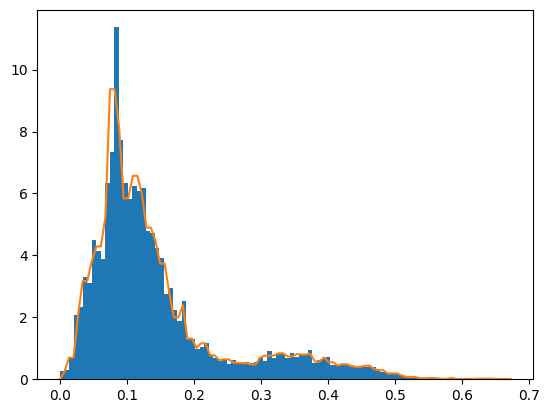

In [22]:
# Calculate the prior

import scipy.stats
hist = np.histogram(data['train'][1], 64)
prior = scipy.stats.rv_histogram(hist)


plt.hist(data['train'][1], 100, density=True);
x = np.linspace(0, data['train'][1].max(), 100)
plt.plot(x, prior.pdf(x));

In [48]:
# This returns the distribution q(z | x) for all clusters
z = np.linspace(0,0.8,100)
logps = []
for i in range(len(z)):
    logps.append(preds.log_prob(z[i]).numpy())
    if i==0:
        print(len(z))
logps = np.stack(logps)

100


In [49]:
logps.shape

(100, 50)

/tmp/ipykernel_109232/1483339771.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(z, np.exp(logps[:,i])/prior.pdf(z), label='posterior under flat prior')


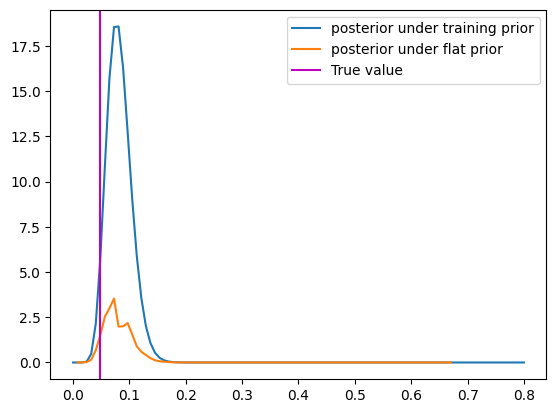

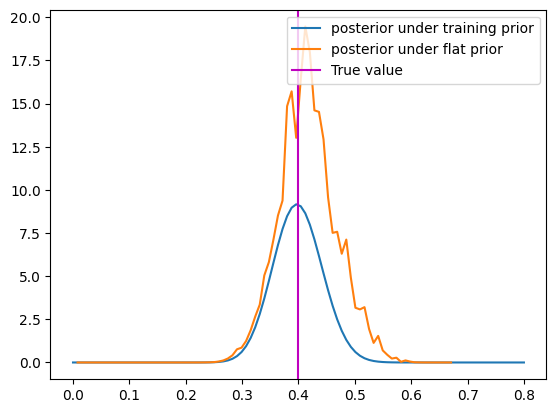

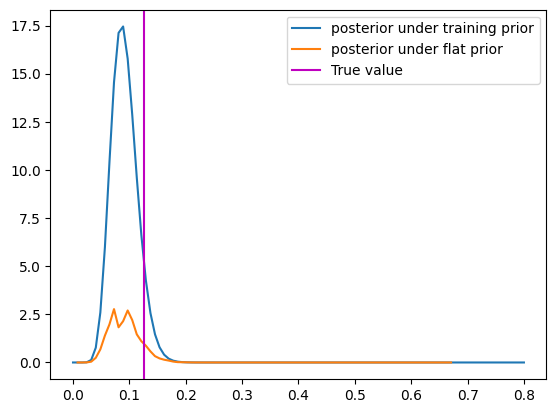

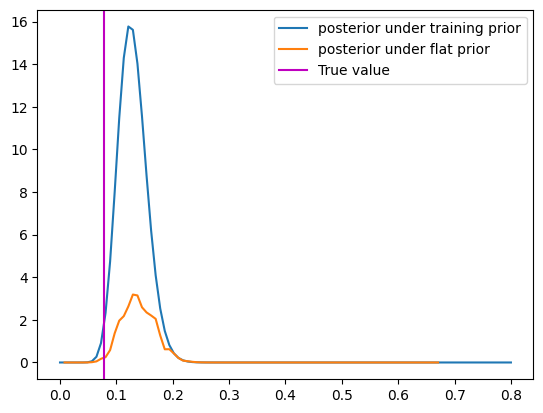

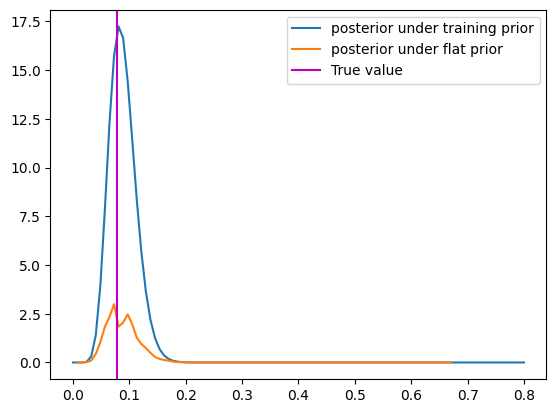

In [50]:
for i in range(5):
    plt.figure()
    plt.plot(z, np.exp(logps[:,i]), label='posterior under training prior')
    plt.plot(z, np.exp(logps[:,i])/prior.pdf(z), label='posterior under flat prior')
    plt.axvline(data['test'][1][i], color='m', label='True value')
    plt.legend()

#### Mean 

In [51]:
# With training prior
point_preds = np.squeeze(preds.mean())

Prediction bias: 0.0014


<IPython.core.display.Latex object>

Outlier fraction: 0.00%


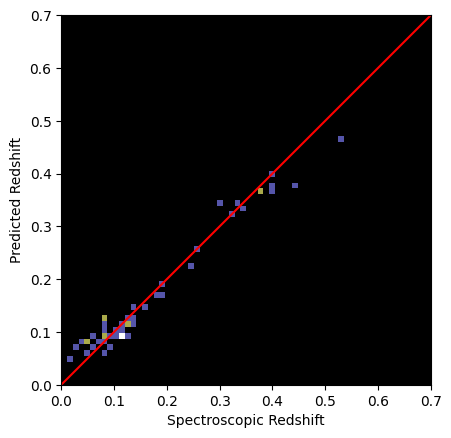

In [52]:
plt.hist2d(data['test'][1][:50], point_preds, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');
dz, pred_bias, smad, out_frac = metrics(data['test'][1][:50], point_preds)
print_metrics(pred_bias, smad, out_frac)

#### Mode 

In [53]:
# With training prior
z_pred_mode = z[np.exp(logps).argmax(axis=0)]

Prediction bias: 0.0014


<IPython.core.display.Latex object>

Outlier fraction: 0.00%


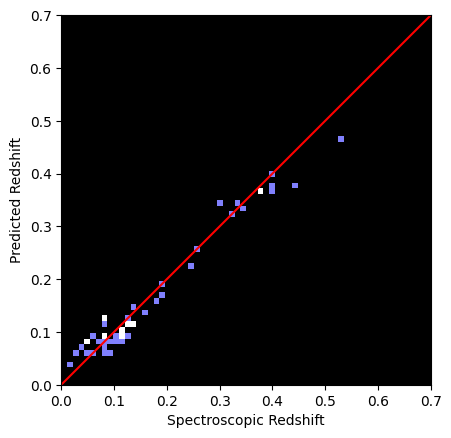

In [56]:
plt.hist2d(data['test'][1][:50], z_pred_mode, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');
dz, pred_bias, smad, out_frac = metrics(data['test'][1][:50], point_preds)
print_metrics(pred_bias, smad, out_frac)